# News Text Classification

Xiaoxiong Xu <br />
Sharis Ochs <br />
Andie Donovan


1. **Summary of the project**: We are classifying BBC news articles into five categories using natural Language Processing and Machine Learning. The five news topics are: Politics, Entertainment, Sports, Technology, and Business. The goal of this project is to create a text classifier that will streamline the process of categorizing news publications. 
<br><br>
2. **Summary of the data**: The dataset consists of 2225 news articles extracted from the BBC website between 2004 and 2005. It was published open source by Insight Resources and was collected by UC Davis for research. The class distribution is as follows:
```
business: 510
entertainment: 386
politics: 417 
sports: 511
technology: 401 
```

### i. Install Modules

In [33]:
import os
import re
import csv
import glob
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark import SparkFiles
from pyspark.ml import Pipeline
from pyspark.ml.feature import *
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import col 
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.mllib.classification import *

sc = SparkContext.getOrCreate()
sqlCtx = SQLContext(sc)

### ii. Load data From BBC News Dataset

In [34]:
# Read file
def read_file(main_df, category):
    for filename in glob.glob('../Data/'+ category + '/*'):
        df = pd.read_csv(filename, sep = "\n", header = None, quoting=csv.QUOTE_NONE)
        df = df.transpose()
        df["text"]= df.apply(lambda x: '\n'.join(x.dropna().astype(str)),axis=1)
        df = df.drop(df.columns[:-1], axis=1)
        df["label"] = category
        main_df = pd.concat([main_df,df],ignore_index=True)
    return main_df

### iii. Add respective labeles

In [35]:
df_news= pd.DataFrame(columns=['text','label'])
list = ['business','politics', 'entertainment','sport','tech']

for genre in list:
    df_news = read_file(df_news, genre)

df_news.head()

,text,label
0,Karachi stocks hit historic high\nThe Karachi ...,business
1,Bombardier chief to leave company\nShares in t...,business
2,Business fears over sluggish EU economy\nAs Eu...,business
3,Stormy year for property insurers\nA string of...,business
4,Euro firms miss out on optimism\nMore than 90%...,business


# 1. Pre-processing and Text Cleanup

## 1.1 Class Distribution and Resampling

In [36]:
df_news.groupby('label').label.count()

label
business         510
entertainment    386
politics         417
sport            511
tech             401
Name: label, dtype: int64

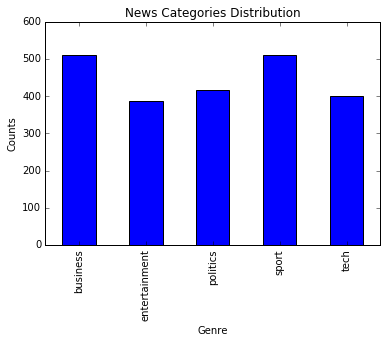

In [37]:
import matplotlib.pyplot as plt

%matplotlib inline

df_news.groupby('label').label.count().plot.bar()
plt.title("News Categories Distribution")
plt.xlabel('Genre')
plt.ylabel('Counts')
plt.show()

## 1.2 Remove Non-Alphanumeric Characters

In [38]:
for row in range(len(df_news)):
    line = df_news.iloc[row,0]
    df_news.iloc[row,0] = re.sub("[^a-zA-Z0-9]", " ", line)

## 1.3 Convert to Lowercase & SQL Dataframe

In [39]:
df_news_lower = df_news.apply(lambda x: x.astype(str).str.lower())
# Convert panda dataframe to sql dataframe
sql_news = sqlCtx.createDataFrame(df_news_lower)

## 1.4. Tokenize Text into Words
RegexTokenizer is a more advanced tokenizing method that uses (regular expression) pattern recognition to parse the text and extract tokens (aka peices of the text body, in this case words). The pattern parameter in the RegexTokenizer function is to identify word characters since we want to break up the text corpuses by words.

In [40]:
regexTokenizer = RegexTokenizer(inputCol="text",
                                outputCol="words",
                                pattern="\\W")
# countTokens = udf(lambda words: len(words), IntegerType())
regexTokenized = regexTokenizer.transform(sql_news).select("words","label")

## 1.5. Remove Stopwords
Stop words are words such as "a", "his", "that", & "and" that do not contribute to the underlying topic or classification of the text and therefore should be filtered out. Although there is no set declaration of what stop words are or should be, we used the built in function StopWordsRemover for simplicity.

In [41]:
remover = StopWordsRemover(inputCol="words", outputCol="cleaned")
removed = remover.transform(regexTokenized).select("cleaned","label")

## 1.6. Stemming 
Stemming is the process of reducing words to their root or "stem" word form. For example "shopping" might be reduced to "shop". This process, which is similar to lemmitization, reduces noise in the word frequency counter

In [42]:
# Conver sql dataframe back to pandas dataframe 
from nltk.stem import SnowballStemmer

df_removed = removed.toPandas()
stemmer = SnowballStemmer('english')
df_removed["words"] = df_removed["cleaned"].apply(lambda x: [stemmer.stem(y) for y in x])

### 1.6.1 Word Clouds

In [43]:
! pip install --user wordcloud

You are using pip version 8.1.2, however version 9.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [44]:
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
from os import path
%matplotlib inline

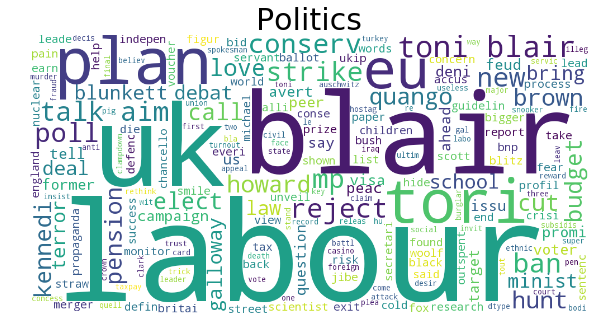

In [45]:
### Politics
pol = df_removed[df_removed['label'] == 'politics']
wordcloud = WordCloud(background_color="white", width = 1000, height = 500).generate(''.join(str(pol["words"])))
plt.figure(figsize=(10,7))
plt.imshow(wordcloud)
plt.title("Politics", fontsize=30)
plt.axis("off")
plt.show()

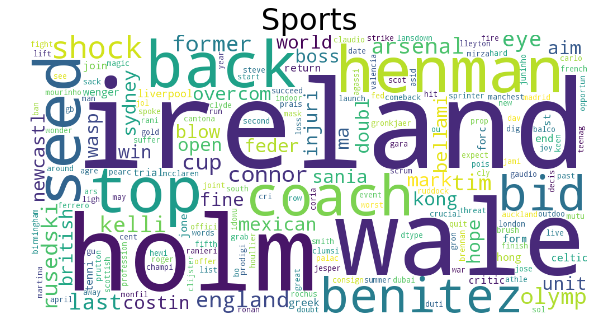

In [46]:
### Sports
spor = df_removed[df_removed['label'] == 'sport']
wordcloud = WordCloud(background_color="white",width = 1000, height = 500).generate(''.join(str(spor["words"])))
plt.figure(figsize=(10,7))
plt.imshow(wordcloud)
plt.title("Sports", fontsize=30)
plt.axis("off")
plt.show()

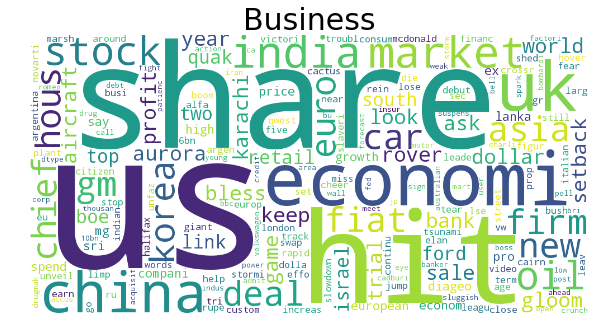

In [47]:
### Business
bus = df_removed[df_removed['label'] == 'business']
wordcloud = WordCloud(background_color="white",width = 1000, height = 500).generate(''.join(str(bus["words"])))
plt.figure(figsize=(10,7))
plt.imshow(wordcloud)
plt.title("Business", fontsize=30)
plt.axis("off")
plt.show()

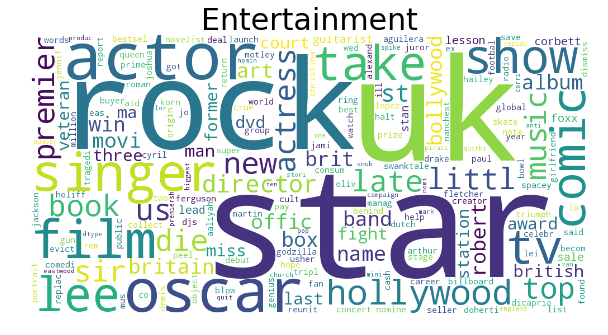

In [48]:
### Entertainment
ent = df_removed[df_removed['label'] == 'entertainment']
wordcloud = WordCloud(background_color="white",width = 1000, height = 500).generate(''.join(str(ent["words"])))
plt.figure(figsize=(10,7))
plt.imshow(wordcloud)
plt.title("Entertainment", fontsize=30)
plt.axis("off")
plt.show()

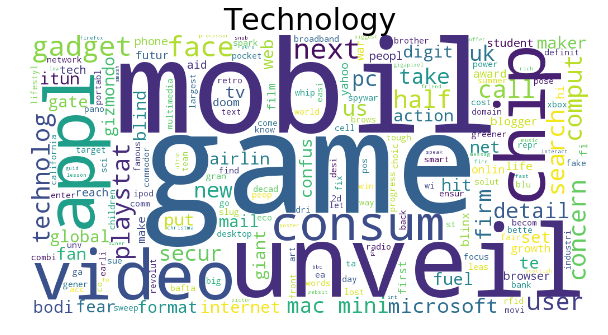

In [49]:
### Tech
tech = df_removed[df_removed['label'] == 'tech']
wordcloud = WordCloud(background_color="white",width = 1000, height = 500).generate(''.join(str(tech["words"])))
plt.figure(figsize=(10,7))
plt.imshow(wordcloud)
plt.title("Technology", fontsize=30)
plt.axis("off")
plt.show()

In [50]:
# Convert back to sql dataframe
stemmed_news = sqlCtx.createDataFrame(df_removed).select(["label","words"])
stemmed_news.show(3)

+--------+--------------------+
|   label|               words|
+--------+--------------------+
|business|[karachi, stock, ...|
|business|[bombardi, chief,...|
|business|[busi, fear, slug...|
+--------+--------------------+
only showing top 3 rows



Before splitting the data, we need to map the data to numeric values. We will use `StringIndexer ` from `pyspark.ml.feature` which is faster for multiclass. In our case, the label column (Category) will be encoded to label indices, from 0 to 4. The most frequent label will be indexed as 0.

In [51]:
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer

indexer = StringIndexer(inputCol = "label", outputCol = "bin_label")
indexed = indexer.fit(stemmed_news).transform(stemmed_news)

In [52]:
indexed.groupBy("bin_label","label").count().orderBy('bin_label').show()

+---------+-------------+-----+
|bin_label|        label|count|
+---------+-------------+-----+
|      0.0|        sport|  511|
|      1.0|     business|  510|
|      2.0|     politics|  417|
|      3.0|         tech|  401|
|      4.0|entertainment|  386|
+---------+-------------+-----+



## 1.7 Splitting Sampled Data to Training and Test Set

In [53]:
# Split data into training(80%) and test(20%), and We are ready to go!
training, test = indexed.randomSplit([0.8, 0.2], seed=42)
training.cache()
test.cache()

(1.0 * training.count()/stemmed_news.count(), 
 1.0 * test.count()/stemmed_news.count(), 
 1.0 * stemmed_news.count()/stemmed_news.count())

(0.7991011235955057, 0.2008988764044944, 1.0)

# 2. Modeling Training and Evaluation

## 2.1 TF-IDF
Term Frequency, Inverse Document Frequecy: Method for determining how important a word is to the overall corpus of news articles.
$$ tf = \frac{f_{t}}{\sum f_{t}}$$
<br>
$$ idf = \frac{log(N)}{n_{t}} $$
<br>
$$ tf idf = tf * idf $$
<br>
$$ = \frac{f_{t}}{\sum f_{t}} * \frac{log(N)}{n_{t}} $$

In [54]:
tf = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures = 10000)
idf = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq=2)

train_tf = tf.transform(training)
test_tf = tf.transform(test)

idfModel = idf.fit(train_tf)
tfidf_train = idfModel.transform(train_tf).select("bin_label", "features")

## 2.2 Random Forest Classifier
Ensemble learning method that uses a collection of decision trees to classify the news articles. Decision trees aim to classify by splitting the data into homogeneous groups (determined by maximum likelihood) based on significant predictors (in our case word counts). Decision trees are fast and non-paramtetic, making them a good addition to our collection of algorithms.

In [55]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.linalg import DenseVector

rescaled_train = tfidf_train.rdd.map(lambda lp: (lp.bin_label, DenseVector(lp.features.toArray()))) \
                                     .toDF(['label','features'])
rescaled_test = test_tf.rdd.map(lambda lp: (lp.bin_label, DenseVector(lp.rawFeatures.toArray()))) \
                                .toDF(['label','features'])

### Model Evaluation Metrics
The model evaluation system/ confusion matrix schema is a little different because of the multiclass problem. Here is the basic layout though:
* Precision (Positive Predictive Value): fraction of those correctly identified over number identified as that class
* Recall (Sensitivity)
* True Negative Rate (Specificity)
* False positive rate (Fall-Out)
* F1 Score: the harmonic mean of precision and recall 
* Accuracy: correctly identified over total

For our model diagnoses, we will be using precision, recall, f1 score, and accuracy:
$$ Precision = \frac{tp}{tp + fp} $$ <br>
$$ Recall = \frac{tp}{tp + fn}$$ <br>
$$ F_{1} = 2 * \frac{(precision * recall)}{(precision + recall)}$$ <br>
$$ Accuracy = \frac{tp + tn}{fp + tp + fn + tn} $$

In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics
# Customized GridSearch

Trees = [50, 100, 200]
Depth = [5, 10, 20]
def runGridSearch_rf(numTrees, numDepth):
    for i in numTrees:
        for j in numDepth:
            rf = RandomForestClassifier(labelCol="label", featuresCol="features", 
                                        numTrees=i, maxDepth= j)
            model = rf.fit(rescaled_train)
            prob = model.transform(rescaled_test)
            pred = prob.select('prediction','label').rdd.map(lambda lp: (lp.prediction,lp.label))
            metrics = MulticlassMetrics(pred)
            print("Accuracy = " + str(metrics.accuracy) +
                  ' , numTrees =' + str(i) +
                  " , maxDepth = " + str(j))

In [ ]:
runGridSearch_rf(Trees, Depth)

Accuracy = 0.863534675615 , numTrees =50 , maxDepth = 5


** According to the result, numTrees = 200 and maxDepth = 20 is the most accurate model**

In [ ]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features", 
                            numTrees=200, maxDepth= 20)
rf_model = rf.fit(rescaled_train)
rf_prob = rf_model.transform(rescaled_test)
rf_pred = rf_prob.select('prediction','label').rdd.map(lambda lp: (lp.prediction,lp.label))

In [ ]:
rf_metrics = MulticlassMetrics(rf_pred) 

# Individual label stats
labels = rf_pred.map(lambda x: x[1]).distinct().collect()
labels.sort()
rf_Evals = pd.DataFrame(columns=['politics','bussiness','sport','entertainment','tech'],
                          index=['Precision','Recall','F1 Score'])

for label in labels:
    rf_Evals.iloc[0][int(label)] = rf_metrics.precision(label)
    rf_Evals.iloc[1][int(label)] = rf_metrics.recall(label)
    rf_Evals.iloc[2][int(label)] = rf_metrics.fMeasure(label)

In [ ]:
rf_Evals

In [ ]:
# Summary
ModelEvals = pd.DataFrame(columns=['Random Forest','Naive Bayes','Multinomial Logistic Regression', 'Nueral Network'],
                          index=['Accuracy','Precision','Recall','F1 Score'])
   
ModelEvals.iloc[0][0]= rf_metrics.accuracy
ModelEvals.iloc[1][0]= rf_metrics.precision()
ModelEvals.iloc[2][0]= rf_metrics.recall()
ModelEvals.iloc[3][0]= rf_metrics.fMeasure()    

In [ ]:
rf_prob.printSchema

## 2.3 Naive Bayes Classifier
Naive Bayes is a classification technique that works well with text and multiclass classification problems by using prior probabilities

$$ P(c|x) = \frac{P(x|c)P(c)}{P(x)} $$

Where c is the classification and x is the predictor (word frequency)

In [ ]:
from pyspark.ml.classification import NaiveBayes

smooth = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
def runGridSearch_nb(smooth_val):
    for i in smooth_val:
        nb = NaiveBayes(smoothing=i, modelType="multinomial")
        model = nb.fit(rescaled_train)
        prob = model.transform(rescaled_test)
        pred = prob.select('prediction','label').rdd.map(lambda lp: (lp.prediction,lp.label))
        metrics = MulticlassMetrics(pred)
        print("Accuracy = " + str(metrics.accuracy) +' , Smoothing = ' + str(i))

In [ ]:
runGridSearch_nb(smooth)

** The optimal value for the smoothing parameter is 0.8 (which achieves the highest accuracy)**

In [ ]:
from pyspark.ml.classification import NaiveBayes

nb = NaiveBayes(smoothing=0.8, modelType="multinomial")
nb_model = nb.fit(rescaled_train)

# select example rows to display.
nb_prob = nb_model.transform(rescaled_test)
nb_pred = nb_prob.select('prediction','label').rdd.map(lambda lp: (lp.prediction,lp.label))

In [ ]:
# Individual label stats
nb_metrics = MulticlassMetrics(nb_pred)  
nb_Evals = pd.DataFrame(columns=['politics','bussiness','sport','entertainment','tech'],
                          index=['Precision','Recall','F1 Score'])

for label in labels:
    nb_Evals.iloc[0][int(label)] = nb_metrics.precision(label)
    nb_Evals.iloc[1][int(label)] = nb_metrics.recall(label)
    nb_Evals.iloc[2][int(label)] = nb_metrics.fMeasure(label)

In [ ]:
nb_Evals

In [ ]:
# Summary stats
ModelEvals.iloc[0][1]= nb_metrics.accuracy
ModelEvals.iloc[1][1]= nb_metrics.precision()
ModelEvals.iloc[2][1]= nb_metrics.recall()
ModelEvals.iloc[3][1]= nb_metrics.fMeasure()   

## 2.4 Multinomial Logistic Classification

In [ ]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import Vector as MLLibVector, Vectors as MLLibVectors

lab_train = rescaled_train.rdd.map(lambda lp: LabeledPoint(lp.label, MLLibVectors.fromML(lp.features)))
lab_test = rescaled_test.rdd.map(lambda lp: LabeledPoint(lp.label, MLLibVectors.fromML(lp.features)))

In [ ]:
mlr = LogisticRegressionWithLBFGS.train(lab_train, iterations=10, numClasses=5)
mlr_prob = lab_test.map(lambda lp: (lp.label,float(mlr.predict(lp.features))))

In [ ]:
mlr_metrics = MulticlassMetrics(mlr_prob) 
mlr_Evals = pd.DataFrame(columns=['politics','bussiness','sport','entertainment','tech'],
                          index=['Precision','Recall','F1 Score'])

for label in labels:
    mlr_Evals.iloc[0][int(label)] = mlr_metrics.precision(label)
    mlr_Evals.iloc[1][int(label)] = mlr_metrics.recall(label)
    mlr_Evals.iloc[2][int(label)] = mlr_metrics.fMeasure(label)

In [ ]:
mlr_Evals

In [ ]:
mlr_metrics = MulticlassMetrics(mlr_prob)    
ModelEvals.iloc[0][2]= mlr_metrics.accuracy
ModelEvals.iloc[1][2]= mlr_metrics.precision()
ModelEvals.iloc[2][2]= mlr_metrics.recall()
ModelEvals.iloc[3][2]= mlr_metrics.fMeasure()    

## 2.5 Neural Network
Here we construct a feedforward artificial neural network as a Multilayer Perceptron Classifier
The layers are as follows: <br>
1. input layers (# predictors)
2. hidden layers
3. output layers (# classes)

[source](https://dzone.com/articles/deep-learning-via-multilayer-perceptron-classifier)

In [ ]:
#https://stackoverflow.com/questions/10565868/multi-layer-perceptron-mlp-architecture-criteria-for-choosing-number-of-hidde
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

hidden = [20, 40, 60, 80, 100]
ite = [50, 100, 200]
block = [50, 100, 200]

def runGridSearch_MPC(iteration, blocksize, hidden_layer):
    for i in iteration:
        for j in blocksize:
            for k in hidden_layer:
                MPC = MultilayerPerceptronClassifier(maxIter=i, layers=[10000, k, 5], 
                                                 blockSize=j, seed=1234)
                model = MPC.fit(rescaled_train)
                prob = model.transform(rescaled_test)
                pred = prob.select('prediction','label').rdd.map(lambda lp: (lp.prediction,lp.label))
                metrics = MulticlassMetrics(pred)
                print("Accuracy = " + str(metrics.accuracy) + ' , maxIter = ' + str(i) +
                      ' , blockSize = ' + str(j) + ' , hidden layers is: ' + str(k))


In [ ]:
runGridSearch_MPC(ite, block, hidden)

**As shown above, many of the combinations of the hyperparameters return the same accuracy. Therefore, we will choose maxIter = 50 , blockSize = 50 , hidden layers = 40 for its high accuracy and low calculation time.**

In [ ]:
MPC = MultilayerPerceptronClassifier(maxIter=50, layers=[10000,40,5], blockSize=50, seed=1234)
MPC_model = MPC.fit(rescaled_train)
MPC_prob = MPC_model.transform(rescaled_test)
MPC_pred = MPC_prob.select("prediction", "label").rdd.map(lambda (prediction,label): (prediction, label))
MPC_metrics = MulticlassMetrics(MPC_pred)

In [ ]:
MPC_Evals = pd.DataFrame(columns=['politics','bussiness','sport','entertainment','tech'],
                         index=['Precision','Recall','F1 Score'])

for label in labels:
    MPC_Evals.iloc[0][int(label)] = MPC_metrics.precision(label)
    MPC_Evals.iloc[1][int(label)] = MPC_metrics.recall(label)
    MPC_Evals.iloc[2][int(label)] = MPC_metrics.fMeasure(label) 

In [ ]:
MPC_Evals

In [ ]:
ModelEvals.iloc[0][3]= MPC_metrics.accuracy
ModelEvals.iloc[1][3]= MPC_metrics.precision()
ModelEvals.iloc[2][3]= MPC_metrics.recall()
ModelEvals.iloc[3][3]= MPC_metrics.fMeasure()

In [ ]:
ModelEvals

# 3. Appendix

### 3.1 Demonstration

**To test the accuracy of our models, we downloaded two current news articles from different genres from the BBC Website. The first file is called `demo.txt` and is technology news.**<br><br>
You can find the link to the technology BBC article used [here](http://www.bbc.com/news/technology-43386918)

In [ ]:
demo = pd.read_csv('../Data/demo.txt', sep = "\n", header = None, quoting=csv.QUOTE_NONE)
demo_df = demo.transpose()
demo_df["text"]= demo_df.apply(lambda x: '\n'.join(x.dropna().astype(str)),axis=1)
demo_df = demo_df.drop(demo_df.columns[:-1], axis=1)
demo_df["label"] = 3.0

for row in range(len(demo_df)):
    line = demo_df.iloc[row,0]
    demo_df.iloc[row,0] = re.sub("[^a-zA-Z0-9]", " ", line)

demo_lower = demo_df.apply(lambda x: x.astype(str).str.lower())
# Convert panda dataframe to sql dataframe
sql_demo = sqlCtx.createDataFrame(demo_lower)
demo_tokenized = regexTokenizer.transform(sql_demo).select("words","label")
demo_remover = StopWordsRemover(inputCol="words", outputCol="cleaned")
demo_removed = demo_remover.transform(demo_tokenized).select("cleaned","label")
demo_removed_df = demo_removed.toPandas()
stemmer = SnowballStemmer('english')
demo_removed_df["words"] = demo_removed_df["cleaned"].apply(lambda x: [stemmer.stem(y) for y in x])
demo_removed_df['bin_label'] = demo_removed_df['label']
stemmed_demo = sqlCtx.createDataFrame(demo_removed_df).select(["bin_label","words"])

In [ ]:
tf_demo = tf.transform(stemmed_demo)
rescaled_demo = tf_demo.rdd.map(lambda lp: (lp.bin_label, DenseVector(lp.rawFeatures.toArray()))) \
                             .toDF(['label','features'])
lab_demo = tf_demo.rdd.map(lambda lp: LabeledPoint(lp.bin_label, MLLibVectors.fromML(lp.rawFeatures)))

In [ ]:
rf_demo = rf_model.transform(rescaled_demo).select('label','prediction').toPandas()
nb_demo = nb_model.transform(rescaled_demo).select('label','prediction').toPandas()
mlr_demo= lab_demo.map(lambda lp: (lp.label,float(mlr.predict(lp.features))))
MPC_demo = MPC_model.transform(rescaled_demo).select('label','prediction').toPandas()

In [ ]:
rf_demo.head()

In [ ]:
nb_demo.head()

In [ ]:
MPC_demo.head()

In [ ]:
mlr_demo.take(1)

**All models were able to predict the article genre correctly. Next we will try `Demonstration.txt`, which is a business article:**
<br><br>
You can find the link to the business BBC article used [here](http://www.bbc.com/news/blogs-trending-43430363)

In [ ]:
demo = pd.read_csv('../Data/Demonstration.txt', sep = "\n", header = None, quoting=csv.QUOTE_NONE)
demo_df = demo.transpose()
demo_df["text"]= demo_df.apply(lambda x: '\n'.join(x.dropna().astype(str)),axis=1)
demo_df = demo_df.drop(demo_df.columns[:-1], axis=1)
demo_df["label"] = 1.0

for row in range(len(demo_df)):
    line = demo_df.iloc[row,0]
    demo_df.iloc[row,0] = re.sub("[^a-zA-Z0-9]", " ", line)

demo_lower = demo_df.apply(lambda x: x.astype(str).str.lower())
# Convert panda dataframe to sql dataframe
sql_demo = sqlCtx.createDataFrame(demo_lower)
demo_tokenized = regexTokenizer.transform(sql_demo).select("words","label")
demo_remover = StopWordsRemover(inputCol="words", outputCol="cleaned")
demo_removed = demo_remover.transform(demo_tokenized).select("cleaned","label")
demo_removed_df = demo_removed.toPandas()
stemmer = SnowballStemmer('english')
demo_removed_df["words"] = demo_removed_df["cleaned"].apply(lambda x: [stemmer.stem(y) for y in x])
demo_removed_df['bin_label'] = demo_removed_df['label']
stemmed_demo = sqlCtx.createDataFrame(demo_removed_df).select(["bin_label","words"])

In [ ]:
tf_demo = tf.transform(stemmed_demo)
rescaled_demo = tf_demo.rdd.map(lambda lp: (lp.bin_label, DenseVector(lp.rawFeatures.toArray()))) \
                             .toDF(['label','features'])
lab_demo = tf_demo.rdd.map(lambda lp: LabeledPoint(lp.bin_label, MLLibVectors.fromML(lp.rawFeatures)))

In [ ]:
rf_demo = rf_model.transform(rescaled_demo).select('label','prediction').toPandas()
nb_demo = nb_model.transform(rescaled_demo).select('label','prediction').toPandas()
mlr_demo= lab_demo.map(lambda lp: (lp.label,float(mlr.predict(lp.features))))
MPC_demo = MPC_model.transform(rescaled_demo).select('label','prediction').toPandas()

In [ ]:
rf_demo.head()

In [ ]:
nb_demo.head()

In [ ]:
MPC_demo.head()

In [ ]:
mlr_demo.take(1)

**According to the results, all models were able to predict the genre correctly.**